### Kick-Off Research
Opted to use the empirical rates of each receiving team yards to goal distances, instead of model. This is because the linear relationships between recieiving team yards to goal and features are extremely weak for kick-offs.

In [ ]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [83]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [84]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [85]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [86]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [550]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    venues = pd.DataFrame([val.to_dict() for val in data])
    venues.columns = convert_to_snake_case(venues.columns)
    venues.to_parquet(file_path)

venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [349]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [434]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [517]:
plays = (
    plays
    .assign(
        pct_game_played = (((plays['period'] - 1) * 15 * 60) + ((15 * 60) - 
                            (plays['clock_minutes'] * 60 + plays['clock_seconds']))) / (4 * 15 * 60),
        seconds_remaining = (plays['period'] - 1) * 15 * 60 + (15 * 60) - (plays['clock_minutes'] * 60 + plays['clock_seconds']),
    )
    .dropna(subset=['game_id', 'drive_number', 'play_number','offense', 'yards_to_goal'])
    .sort_values(['game_id','pct_game_played'], ascending=[True, True])
)

kickoff_plays_types = ["Kickoff", "Kickoff Return (Offense)", "Kickoff Return Touchdown"]
kickoff_plays = (
    plays.copy()
    .assign(
        next_play_number = plays.groupby('game_id')['play_number'].shift(-1),
        next_drive_number = plays.groupby('game_id')['drive_number'].shift(-1),
        next_offense = plays.groupby('game_id')['offense'].shift(-1),
        next_game_id = plays.groupby('game_id')['game_id'].shift(-1),
        next_yards_to_goal = plays.groupby('game_id')['yards_to_goal'].shift(-1),
        next_pct_game_played = plays.groupby('game_id')['pct_game_played'].shift(-1),
        next_seconds_remaining = plays.groupby('game_id')['seconds_remaining'].shift(-1),
    )
    .query('play_type in @kickoff_plays_types')
    .reset_index(drop=True)
)

kickoff_plays = (
    kickoff_plays[
        (
            (kickoff_plays['play_type'].isin(kickoff_plays_types)) &
            # (kickoff_plays['next_drive_number'] == (kickoff_plays['drive_number'] + 1)) &
            (kickoff_plays['next_offense'] != kickoff_plays['offense']) &
            # (kickoff_plays['next_play_number'] == 1) &
            (kickoff_plays['pct_game_played'] <= kickoff_plays['next_pct_game_played']) &
            (kickoff_plays['next_pct_game_played'] <= (kickoff_plays['pct_game_played'] + 0.01)) &
            (kickoff_plays['next_game_id'] == kickoff_plays['game_id']) 
        ) |
        (
            (kickoff_plays['play_type'] == 'Kickoff Return Touchdown')
        )
    ]
)

kickoff_plays['receiving_team_yards_to_goal'] = np.where(
    kickoff_plays['play_type'] == 'Kickoff Return Touchdown',
    0,
    kickoff_plays['next_yards_to_goal']
)

kickoff_plays = (
    kickoff_plays[['game_id', 'offense', 'defense', 'receiving_team_yards_to_goal']]
    .assign(
        receiving_team_yards_to_goal = np.where(
            kickoff_plays.receiving_team_yards_to_goal < 0,
            0,
            np.where(
                kickoff_plays.receiving_team_yards_to_goal > 100,
                99,
                kickoff_plays.receiving_team_yards_to_goal
            )
        ),
        seconds_used = kickoff_plays['seconds_remaining'] - kickoff_plays['next_seconds_remaining'],
    )
)

kickoff_plays.shape

(54860, 5)

In [567]:
wp_go = .42
wp_punt = .38
wp_fg = .32
wp_curr = .4
std_dev_go = 2
std_dev_punt = 0.005
std_dev_fg = 0.05

print(f'Sharp Ratio Go: {(wp_go - wp_curr) / std_dev_go:.2f}')
print(f'Sharp Ratio Punt: {(wp_punt - wp_curr) / std_dev_punt:.2f}')
print(f'Sharp Ratio FG: {(wp_fg - wp_curr) / std_dev_fg:.2f}')

Sharp Ratio Go: 0.01
Sharp Ratio Punt: -4.00
Sharp Ratio FG: -1.60


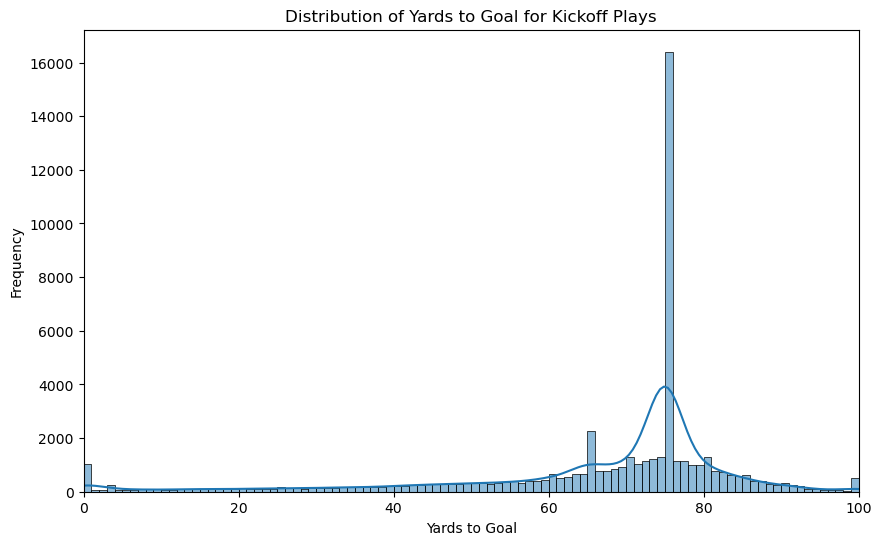

In [509]:
#plot the dist of yards to goal for kickoff plays
plt.figure(figsize=(10, 6))
sns.histplot(kickoff_plays['receiving_team_yards_to_goal'], bins=100, kde=True)
plt.title('Distribution of Yards to Goal for Kickoff Plays')
plt.xlabel('Yards to Goal')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()

In [518]:
cols = ['temperature', 'wind_speed', 'precipitation', 'elevation', 
    'kicking_team_pregame_elo', 'receiving_team_pregame_elo','game_indoors']

for col in cols:
    if col in kickoff_plays.columns:
        kickoff_plays.drop(columns=[col], inplace=True)

kickoff_plays = (
    kickoff_plays.merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']],
        left_on='game_id',
        right_on='id',
        how='left'
    ).drop(columns=['id'])
    .merge(
        games[['id','season','week','venue_id']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']].rename(columns={'team': 'offense', 'elo': 'kicking_team_pregame_elo'}),
        on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']].rename(columns={'team': 'defense', 'elo': 'receiving_team_pregame_elo'}),
        on=['season', 'week', 'defense'],
        how='left'
    )
    .merge(
        venues[['id', 'elevation']].rename(columns={'id': 'venue_id'}),
        on='venue_id',
        how='left'
    ).drop(columns=['venue_id', 'season', 'week'])
)

kickoff_plays = (
    kickoff_plays
    .assign(
        wind_speed = np.where(kickoff_plays.game_indoors, 0, kickoff_plays.wind_speed.fillna(int(kickoff_plays.wind_speed.mean()))),
        elevation = kickoff_plays.elevation.fillna(int(kickoff_plays.elevation.astype(float).mean())),
        precipitation = np.where(kickoff_plays.game_indoors, 0, kickoff_plays.precipitation.fillna(int(kickoff_plays.precipitation.mean()))),
        temperature = np.where(kickoff_plays.game_indoors, 70, kickoff_plays.temperature.fillna(int(kickoff_plays.temperature.mean()))),
    )
    .drop(columns=['game_indoors'])
)

kickoff_plays['elevation'] = kickoff_plays['elevation'].astype(float)    

kickoff_plays = kickoff_plays[
    [
        'game_id', 'offense', 'defense', 'kicking_team_pregame_elo', 
        'receiving_team_pregame_elo', 'temperature', 'wind_speed', 
        'precipitation', 'elevation', 'seconds_used', 'receiving_team_yards_to_goal'
    ]
]

100%|██████████| 6/6 [00:24<00:00,  4.04s/it]


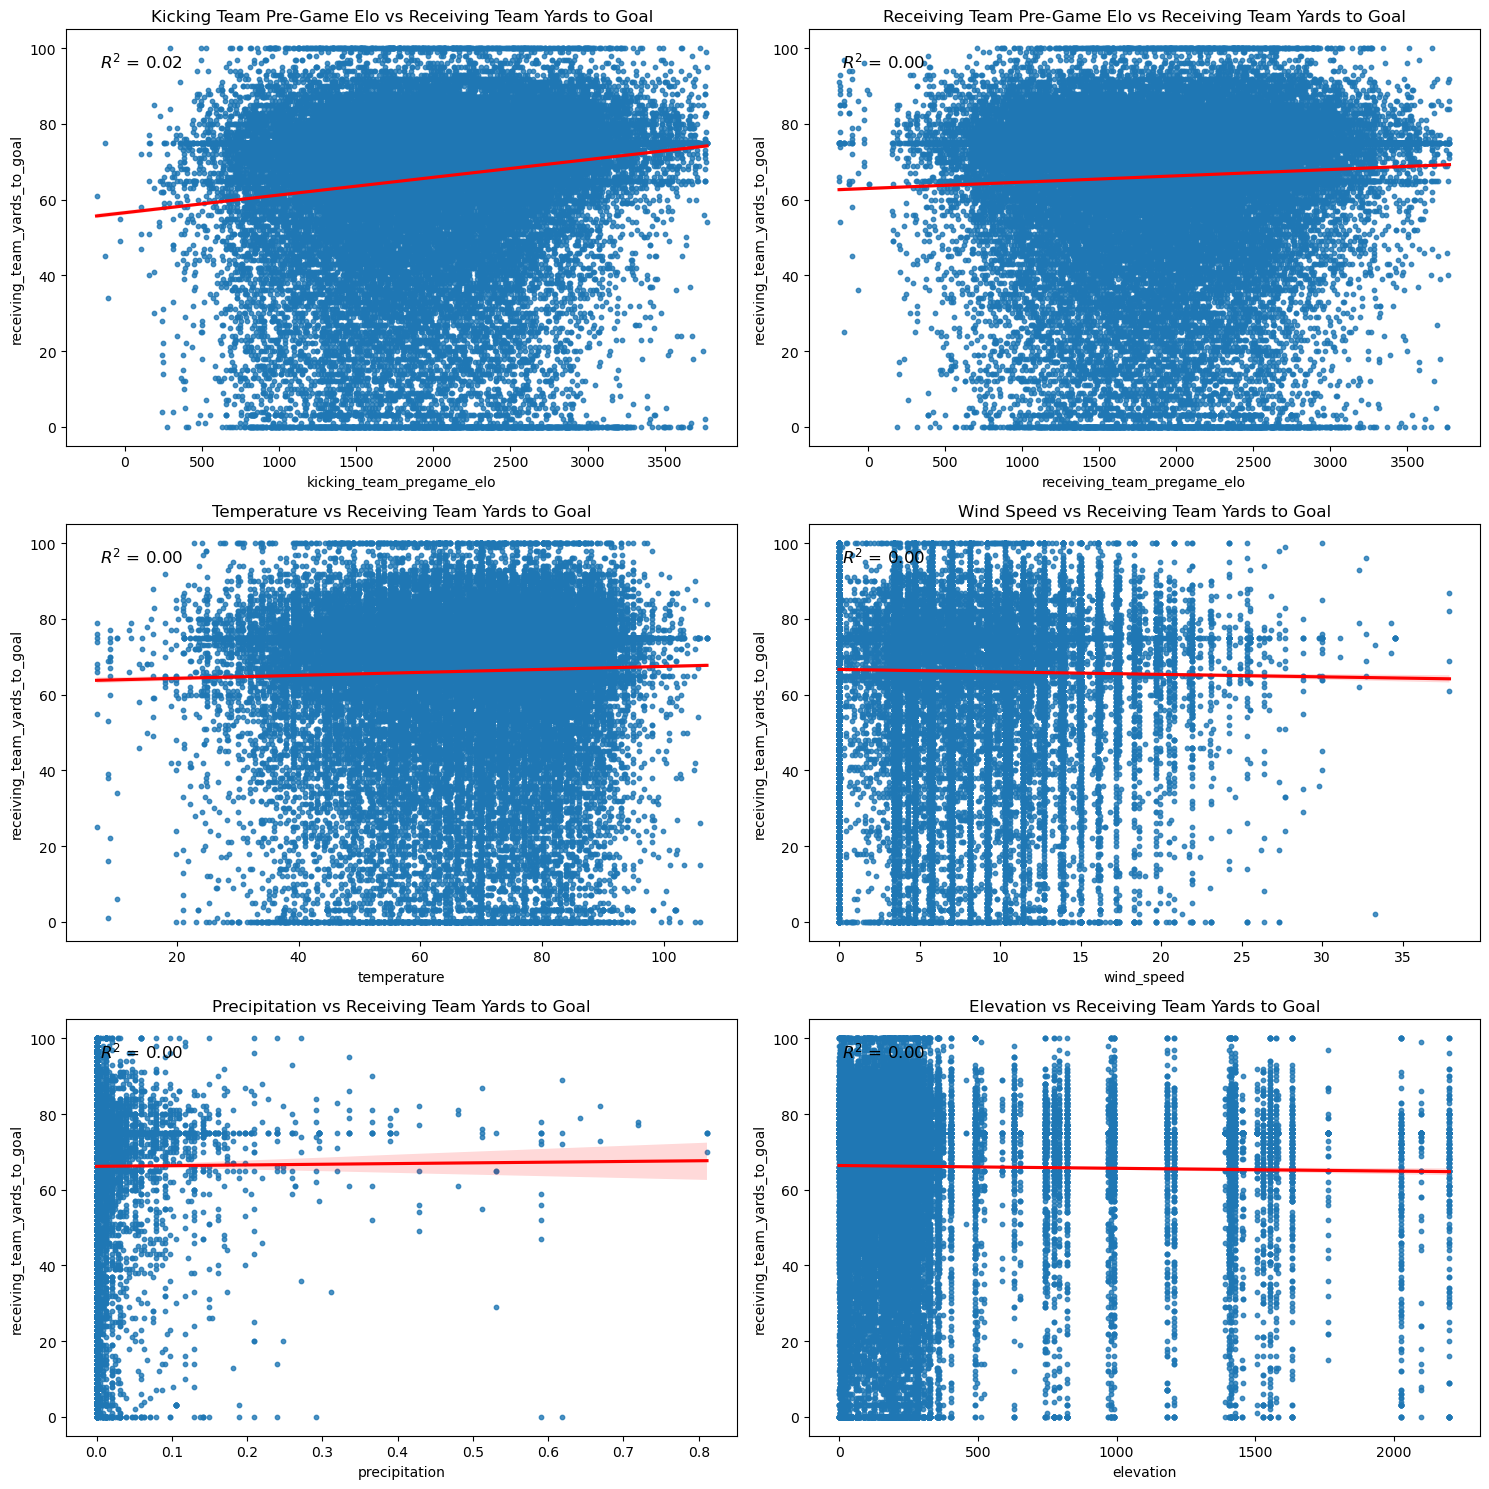

In [511]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

features = [
    ('kicking_team_pregame_elo', 'Kicking Team Pre-Game Elo vs Receiving Team Yards to Goal'),
    ('receiving_team_pregame_elo', 'Receiving Team Pre-Game Elo vs Receiving Team Yards to Goal'),
    ('temperature', 'Temperature vs Receiving Team Yards to Goal'),
    ('wind_speed', 'Wind Speed vs Receiving Team Yards to Goal'),
    ('precipitation', 'Precipitation vs Receiving Team Yards to Goal'),
    ('elevation', 'Elevation vs Receiving Team Yards to Goal')
]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for ax, (feature, title) in tqdm(zip(axes.flat, features), total=len(features)):
    # Drop NA for both x and y
    df = kickoff_plays[[feature, 'receiving_team_yards_to_goal']].dropna()
    x = df[feature].values.reshape(-1, 1)
    y = df['receiving_team_yards_to_goal'].values

    # Scatter + regression line
    sns.regplot(x=df[feature], y=df['receiving_team_yards_to_goal'], ax=ax, scatter_kws={'s': 10}, line_kws={'color': 'red'})

    # Fit linear regression for R^2
    if len(x) > 1:
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        r2 = r2_score(y, y_pred)
        ax.text(0.05, 0.95, f'$R^2$ = {r2:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    else:
        ax.text(0.05, 0.95, f'Not enough data', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    ax.set_title(title)

plt.tight_layout()
plt.show()

In [512]:
# fit linear regression with the feature kicking_team_pregame_elo, receiving_team_pregame_elo, temperature, wind_speed, precipitation, elevation
# output the coefficients and intercept, as well as the p values
from statsmodels.api import OLS, add_constant
def fit_linear_regression(df, features, target):
    X = df[features]
    y = df[target]
    
    X = add_constant(X)  # Adds a constant term to the predictor
    model = OLS(y, X).fit()
    
    return model

features = [
    'kicking_team_pregame_elo', 
    'receiving_team_pregame_elo', 
    'temperature', 
    'wind_speed', 
    'precipitation', 
    'elevation'
]
model = fit_linear_regression(kickoff_plays, features, 'receiving_team_yards_to_goal')
print(model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     receiving_team_yards_to_goal   R-squared:                       0.027
Model:                                      OLS   Adj. R-squared:                  0.026
Method:                           Least Squares   F-statistic:                     249.5
Date:                          Sat, 14 Jun 2025   Prob (F-statistic):          5.48e-316
Time:                                  20:01:50   Log-Likelihood:            -2.4015e+05
No. Observations:                         54860   AIC:                         4.803e+05
Df Residuals:                             54853   BIC:                         4.804e+05
Df Model:                                     6                                         
Covariance Type:                      nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

#### Very low R^2 using OLS. Just going to sample from empirical distibution.

For the time used by kick return, assume the following
1. Touchback -> 0 seconds used
2. Return > 75 ytg (short return) -> 4 seconds used
3. Anything above 75 ytg, is a linear function between 75 and 0, with time used at zero being 10 and at 75 being 4.

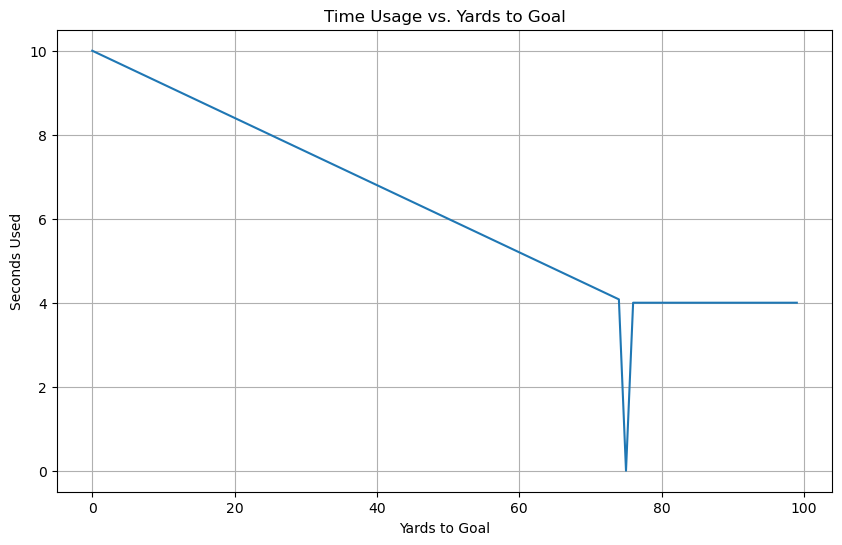

In [539]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 100, 1)

# Define the piecewise function
y = np.where(
    x > 75,  
    4,
    np.where(
        x==75,
        0,
        4 + (6 / 75) * (75 - x)
    )
)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel('Yards to Goal')
plt.ylabel('Seconds Used')
plt.title('Time Usage vs. Yards to Goal')
plt.grid(True)
plt.show()

In [544]:
kickoff_plays.receiving_team_yards_to_goal.value_counts()

receiving_team_yards_to_goal
75.0     16404
65.0      2264
80.0      1307
70.0      1302
74.0      1284
73.0      1220
72.0      1152
77.0      1152
76.0      1136
0.0       1048
71.0      1034
79.0      1002
78.0      1000
69.0       915
68.0       835
66.0       783
81.0       770
67.0       755
82.0       750
64.0       662
60.0       656
63.0       646
83.0       638
85.0       620
84.0       595
62.0       567
61.0       506
100.0      454
59.0       432
58.0       408
57.0       398
55.0       398
87.0       391
86.0       387
54.0       350
53.0       343
56.0       340
50.0       331
90.0       324
51.0       314
49.0       311
52.0       296
46.0       282
47.0       277
88.0       277
44.0       276
48.0       275
45.0       273
3.0        260
43.0       250
89.0       244
42.0       239
91.0       232
41.0       219
39.0       215
92.0       205
40.0       203
38.0       177
35.0       172
33.0       169
34.0       167
37.0       166
36.0       165
25.0       158
29.0       

In [548]:
# bin the data into bins of 1 from 0 to 99 yards, calculate probabilites of each bin
bins = np.arange(-1, 100, 1)
binned_kickoff_ytg = (
    pd.cut(
        kickoff_plays['receiving_team_yards_to_goal'], 
        bins=bins, 
        include_lowest=True
    )
    .value_counts(normalize=True)
    .sort_index()
    .reset_index()
    .reset_index()
    .drop(columns='receiving_team_yards_to_goal')
    .rename(columns={
        # 'receiving_team_yards_to_goal': 'bins',
        'index': 'receiving_team_ytg',
        'proportion': 'empirical_proba'
    })
)

condlist = [
    binned_kickoff_ytg.receiving_team_ytg == 75, # touchback
    binned_kickoff_ytg.receiving_team_ytg < 75, # base 4 seconds used assumption
    binned_kickoff_ytg.receiving_team_ytg > 75
]

binned_kickoff_ytg['seconds_used'] = np.where(
    binned_kickoff_ytg.receiving_team_ytg > 75,  
    4,
    np.where(
        binned_kickoff_ytg.receiving_team_ytg == 75,
        0,
        4 + (6 / 75) * (75 - binned_kickoff_ytg.receiving_team_ytg)
    )
).round(2)

binned_kickoff_ytg

,receiving_team_ytg,empirical_proba,seconds_used
0,0,0.019263,10.00
1,1,0.001011,9.92
2,2,0.001084,9.84
3,3,0.004779,9.76
4,4,0.001121,9.68
5,5,0.001360,9.60
6,6,0.001231,9.52
7,7,0.001581,9.44
8,8,0.001728,9.36
9,9,0.001617,9.28


In [ ]:
model_dir = join('../models/raw', 'kickoff')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

binned_kickoff_ytg.to_parquet(join('../models/raw/kickoffs', 'kickoff_binned_probabilities.parquet'), index=False)